In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from dataloader import *
from functools import reduce
from torch.autograd import Variable
from tqdm import tqdm
%matplotlib inline

## Model 

In [2]:
class Model(nn.Module):
    def __init__(self,num_layers):
        super(Model,self).__init__()
        self.net = nn.Sequential(nn.ReflectionPad2d(1),nn.Conv2d(1,1,3,bias=False))
        self.model1 = nn.ModuleList([self.net for i in range(num_layers)])
        self.model2 = nn.ModuleList([self.net for i in range(num_layers)])
        self.model3 = nn.ModuleList([self.net for i in range(num_layers)])
        self.model4 = nn.ModuleList([self.net for i in range(num_layers)])
#         self.model = nn.Sequential(self.model1)
    def forward(self,x):
#         print(x)
        x1 = reduce(lambda acc, el: el(acc), self.model1, x)
        x2 = reduce(lambda acc, el: el(acc), self.model2, x)
        x3 = reduce(lambda acc, el: el(acc), self.model3, x)
        x4 = reduce(lambda acc, el: el(acc), self.model4, x)
        
        x = torch.cat((x1,x2,x3,x4),1)
        return x

### Dataloader used to get data

In [3]:
num_workers = 1
train_batch_size = 256
val_batch_size = 1
trainData = Ipde('./data/train_data/')
valData = Ipde('./data/val_data/')
# testData = Ipde('./data/test_data/')

# delta X
nx = 64.
delx = 2.*3.14/nx
delt = 0.1

trainDataloader = DataLoader(trainData,num_workers=num_workers,batch_size=train_batch_size)
valDataloader = DataLoader(valData,num_workers=num_workers,batch_size=val_batch_size)
# testDataloader = DataLoader(testData,num_workers,batch_size)

trainIter = iter(trainDataloader)
train = trainIter.next()
valIter = iter(valDataloader)
val = valIter.next()

In [ ]:
int(os.path.split(os.path.split(trainData.data[0])[0])[1].zfill(3)+os.path.split(trainData.data[0])[1][:-4].zfill(3))

In [ ]:
l = ['file-1', 'file-9', 'file-2', 'file-10']
sorted( l, key=lambda a: int(a.split("-")[1]) )

In [4]:
def psi_input(u):
    filter_1 = np.expand_dims(np.expand_dims(np.array([[0,0,0],[-0.5,0,0.5],[0,0,0]]),0),0)/delx
    filter_2 = np.expand_dims(np.expand_dims(np.array([[0,-0.5,0],[0,0,0],[0,0.5,0]]),0),0)/delx
    filter_3 = np.expand_dims(np.expand_dims(np.array([[0,0,0],[1.,-2.,1.],[0,0,0]]),0),0)/(delx**2)
    filter_4 = np.expand_dims(np.expand_dims(np.array([[0,1.,0],[0,-2.,0],[0,1.,0]]),0),0)/(delx**2)
    Filter_var = np.concatenate([filter_1,filter_2,filter_3,filter_4],axis=0)
    if(torch.cuda.is_available()!=False):
        Filter_var = Variable(torch.FloatTensor(Filter_var).cuda(), requires_grad=False)
    else:
        Filter_var = Variable(torch.FloatTensor(Filter_var), requires_grad=False)            
    out = F.conv2d(u, Filter_var, stride=1, padding=(1, 1))
    return out

In [5]:
def parameter_mult(psi,parameters):
#     print(psi.shape,parameters.shape)
    out = torch.mul(psi,parameters.unsqueeze(-1).unsqueeze(-1))
    output = out[:,0:1,:,:]+out[:,1:2,:,:]+out[:,2:3,:,:]+out[:,3:4,:,:]
    return output

In [6]:
model = Model(3)

In [10]:
def phi_input(u, parameters, delta_t):
    w = parameter_mult(psi_input(u), parameters)*delta_t
    psi = w + u
#     print(model(input_to_net).shape)
    convmodel = torch.sum(parameter_mult(model(w), parameters)*0.5*delta_t, 1, keepdim=True)
    return psi,convmodel + psi

In [8]:
# No of parameters in the network
sum(p.numel() for p in model.parameters())

9

### Loss Functions and optimization

In [9]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=10, betas=(0.9,0.99), weight_decay=0)

In [12]:
num_epochs = 25
if (torch.cuda.is_available()==1):
    print('CUDA Training')
    model.cuda()

model.train()
for epoch in range(1,num_epochs+1):
    train_loss = 0.0
#     fdm_train_loss = 0.0
    for parameter,data,target in trainDataloader:
    
        if(torch.cuda.is_available()):
            data = data.type(torch.FloatTensor).cuda()
            parameter = parameter.type(torch.FloatTensor).cuda()
            target = target.type(torch.FloatTensor).cuda()
        else:
            data = data.type(torch.FloatTensor)
            parameter = parameter.type(torch.FloatTensor)
            target = target.type(torch.FloatTensor)
        
        optimizer.zero_grad()
        fdm_op,output = phi_input(data, parameter, 0.1)
        loss = criterion(output, target)
#         fdm_loss = criterion(fdm_op,target)
        loss.backward()
#         fdm_loss.backward()
        optimizer.step()
        train_loss += loss.item()
#         fdm_train_loss += fdm_loss.item()
    train_loss = train_loss/len(trainDataloader)
#     fdm_train_loss = fdm_train_loss/len(trainDataloader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
#     print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, fdm_train_loss))    

CUDA Training
Epoch: 1 	Training Loss: 10443.774145
Epoch: 2 	Training Loss: 316.153879
Epoch: 3 	Training Loss: 12.997516
Epoch: 4 	Training Loss: 1.185373
Epoch: 5 	Training Loss: 0.395037
Epoch: 6 	Training Loss: 0.221574
Epoch: 7 	Training Loss: 0.140058
Epoch: 8 	Training Loss: 0.093687
Epoch: 9 	Training Loss: 0.065072
Epoch: 10 	Training Loss: 0.046461
Epoch: 11 	Training Loss: 0.033882
Epoch: 12 	Training Loss: 0.025128
Epoch: 13 	Training Loss: 0.018892
Epoch: 14 	Training Loss: 0.014366
Epoch: 15 	Training Loss: 0.011032
Epoch: 16 	Training Loss: 0.008544
Epoch: 17 	Training Loss: 0.006668
Epoch: 18 	Training Loss: 0.005240
Epoch: 19 	Training Loss: 0.004145
Epoch: 20 	Training Loss: 0.003300
Epoch: 21 	Training Loss: 0.002643
Epoch: 22 	Training Loss: 0.002130
Epoch: 23 	Training Loss: 0.001727
Epoch: 24 	Training Loss: 0.001409
Epoch: 25 	Training Loss: 0.001157


In [13]:
model.eval()
for epoch in range(1,num_epochs+1):
    val_loss = 0.0
    for parameter,data,target in valDataloader:
        if(torch.cuda.is_available()):
            data = data.type(torch.FloatTensor).cuda()
            parameter = parameter.type(torch.FloatTensor).cuda()
            target = target.type(torch.FloatTensor).cuda()
        else:
            data = data.type(torch.FloatTensor)
            parameter = parameter.type(torch.FloatTensor)
            target = target.type(torch.FloatTensor)
        
        fdm_op, output = phi_input(data,parameter,0.1)
        loss = criterion(output,target)
        val_loss += loss.item()
#         val_loss.append(loss.data.cpu().nuoutput = phi_input(data,parameter,0.1)
        loss = criterion(output,target)
        val_loss += loss.item()
#         val_loss.append(loss.data.cpu().numpy())
    val_loss_epoch = val_loss/len(valDataloader)
    print('Epoch: {} \tValidation Loss: {:.6f}'.format(epoch, val_loss_epoch))

Epoch: 1 	Validation Loss: 0.001285
Epoch: 2 	Validation Loss: 0.001285
Epoch: 3 	Validation Loss: 0.001285
Epoch: 4 	Validation Loss: 0.001285
Epoch: 5 	Validation Loss: 0.001285
Epoch: 6 	Validation Loss: 0.001285
Epoch: 7 	Validation Loss: 0.001285
Epoch: 8 	Validation Loss: 0.001285
Epoch: 9 	Validation Loss: 0.001285
Epoch: 10 	Validation Loss: 0.001285
Epoch: 11 	Validation Loss: 0.001285
Epoch: 12 	Validation Loss: 0.001285
Epoch: 13 	Validation Loss: 0.001285
Epoch: 14 	Validation Loss: 0.001285
Epoch: 15 	Validation Loss: 0.001285
Epoch: 16 	Validation Loss: 0.001285
Epoch: 17 	Validation Loss: 0.001285
Epoch: 18 	Validation Loss: 0.001285
Epoch: 19 	Validation Loss: 0.001285
Epoch: 20 	Validation Loss: 0.001285
Epoch: 21 	Validation Loss: 0.001285
Epoch: 22 	Validation Loss: 0.001285
Epoch: 23 	Validation Loss: 0.001285
Epoch: 24 	Validation Loss: 0.001285
Epoch: 25 	Validation Loss: 0.001285


## Plot the losses

In [ ]:
x = np.array(train_loss)
y = np.array(val_loss)

In [ ]:
plt.figure()
plt.plot(x)
plt.plot(y)
plt.show()

0.005748415036560411


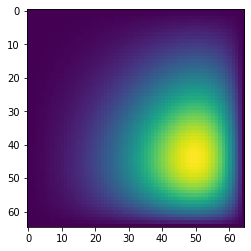

In [15]:
model.eval()
tot_error = 0.0
for parameter,data,target in valDataloader:
    if(torch.cuda.is_available()):
        data = data.type(torch.FloatTensor).cuda()
        parameter = parameter.type(torch.FloatTensor).cuda()
        target = target.type(torch.FloatTensor).cuda()
    else:
        data = data.type(torch.FloatTensor)
        parameter = parameter.type(torch.FloatTensor)
        target = target.type(torch.FloatTensor)
        
    fdm_op,output = phi_input(data,parameter,0.1)
    fdm_op = fdm_op.cpu().detach().numpy()
    data = data.cpu().detach().numpy()
    output = output.cpu()
    output = output.detach().numpy()
    output = output.squeeze(0)
    image = plt.imshow(output.squeeze(0))
    input_image = plt.imshow(data.squeeze(0).squeeze(0))
    
    error = np.sqrt(np.mean((output - data)**2))
#     print('root mean square error',error)
    tot_error += error
avg_error = tot_error/len(valDataloader)
print(avg_error)

## Save the model

In [ ]:
torch.save(model,'./Model/model.pt')

## Inference

In [16]:
#Load the testdata
num_workers = 1
batch_size = 1
testData = Ipde('./data/test_data/')


testDataloader = DataLoader(trainData,num_workers=num_workers,batch_size=batch_size)

testIter = iter(testDataloader)
test = testIter.next()

In [17]:
model.eval()
tot_error = 0.0
for parameter,data,target in testDataloader:
    if(torch.cuda.is_available()):
        data = data.type(torch.FloatTensor).cuda()
        parameter = parameter.type(torch.FloatTensor).cuda()
        target = target.type(torch.FloatTensor).cuda()
    else:
        data = data.type(torch.FloatTensor)
        parameter = parameter.type(torch.FloatTensor)
        target = target.type(torch.FloatTensor)
        
    fdm_op,output = phi_input(data,parameter,0.1)
    fdm_op = fdm_op.cpu().detach().numpy()
    data = data.cpu().detach().numpy()
    output = output.cpu()
    output = output.detach().numpy()
    output = output.squeeze(0)
    image = output.squeeze(0)
    input_image = data.squeeze(0).squeeze(0) 
    error = np.sqrt(np.mean((output - data)**2))
#     print('root mean square error',error)
    tot_error += error
avg_error = tot_error/len(testDataloader)
print(avg_error)

0.007978534624860766


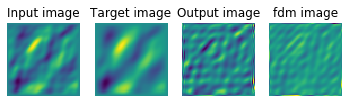

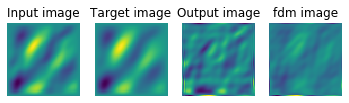

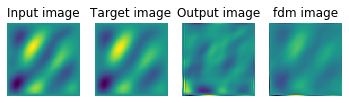

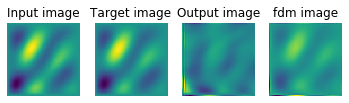

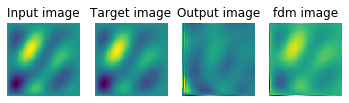

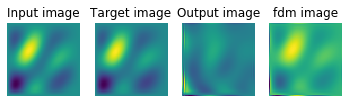

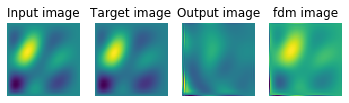

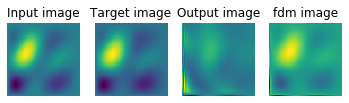

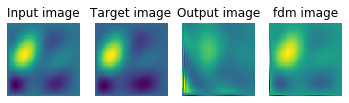

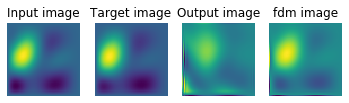

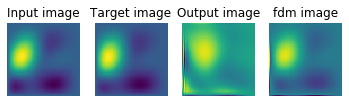

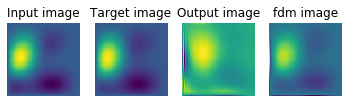

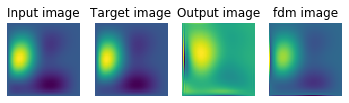

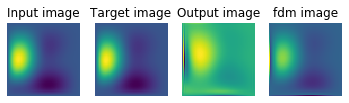

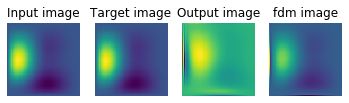

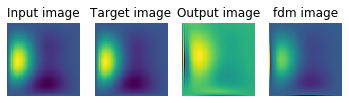

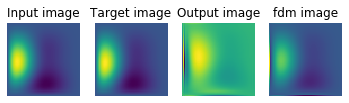

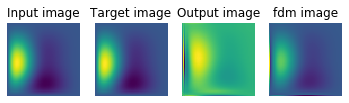

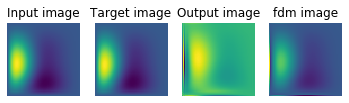

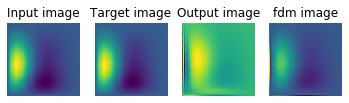

In [18]:
#plot some images
counter = 0
for i,(parameter,data,target) in enumerate(testDataloader):
    if(torch.cuda.is_available()):
        data = data.type(torch.FloatTensor).cuda()
        parameter = parameter.type(torch.FloatTensor).cuda()
        target = target.type(torch.FloatTensor).cuda()
    else:
        data = data.type(torch.FloatTensor)
        parameter = parameter.type(torch.FloatTensor)
        target = target.type(torch.FloatTensor)
        
    fdm_op,output = phi_input(data,parameter,0.1)
    data = data.cpu().detach().numpy()
    fdm_op = fdm_op.cpu().detach().numpy()
    target = target.cpu().detach().numpy()
    output = output.cpu()
    output = output.detach().numpy()
    output = output.squeeze(0)
    fdm_image = fdm_op.squeeze(0).squeeze(0)
    image = output.squeeze(0)
    input_image = data.squeeze(0).squeeze(0)
    target_image = target.squeeze(0).squeeze(0)
    plt.figure(i)
    plt.subplot(1,4,1)
    plt.title('Input image')
    plt.axis('off')
    plt.imshow(input_image)
    plt.subplot(1,4,2)
    plt.title('Target image')
    plt.axis('off')
    plt.imshow(target_image)
    plt.subplot(1,4,3)
    plt.title('Output image')
    plt.axis('off')
    plt.imshow(image)
    plt.subplot(1,4,4)
    plt.title('fdm image')
    plt.axis('off')
    plt.imshow(fdm_image)
    counter+=1
    if(counter == 20):
        break

## Load the model and test on 128x128 grid size

In [ ]:
torch.load('./Model/model.pt')

In [17]:
num_workers = 1
batch_size = 1
testData = Ipde('./data/128/')


testDataloader = DataLoader(testData,num_workers=num_workers,batch_size=batch_size)

testIter = iter(testDataloader)
test = testIter.next()

0.0018335976493544877


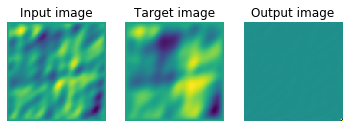

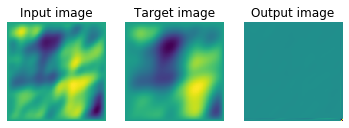

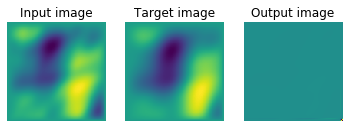

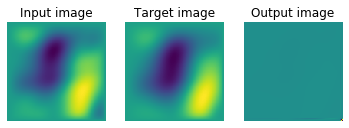

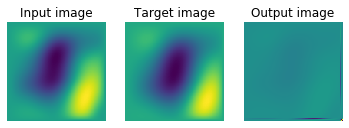

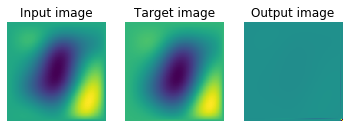

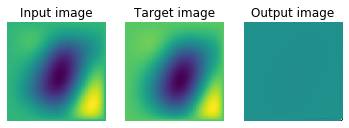

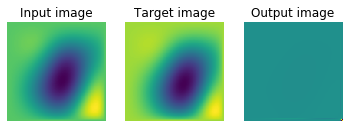

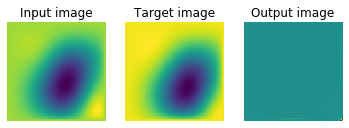

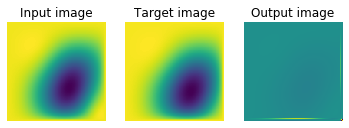

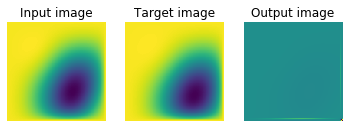

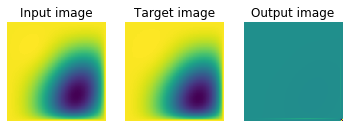

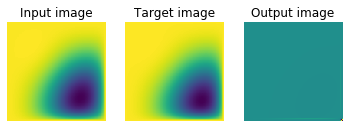

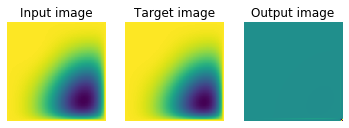

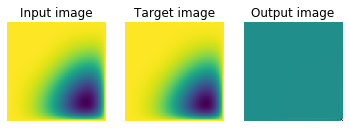

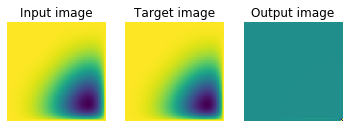

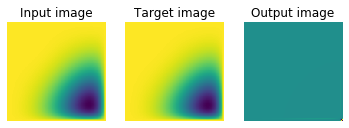

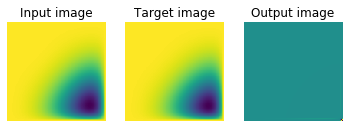

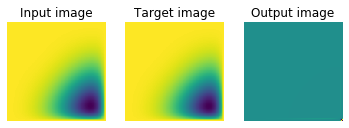

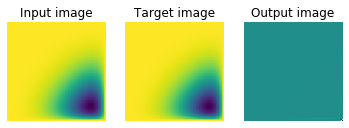

In [18]:
model.eval()
counter = 0
tot_error = 0.0
for i,(parameter,data,target) in enumerate(testDataloader):
    if(torch.cuda.is_available()):
        model = model.cuda()
        data = data.type(torch.FloatTensor).cuda()
        parameter = parameter.type(torch.FloatTensor).cuda()
        target = target.type(torch.FloatTensor).cuda()
    else:
        data = data.type(torch.FloatTensor)
        parameter = parameter.type(torch.FloatTensor)
        target = target.type(torch.FloatTensor)
        
    output = phi_input(data,parameter,0.1)
    data = data.cpu().detach().numpy()
    target = target.cpu().detach().numpy()
    output = output.cpu()
    output = output.detach().numpy()
    output = output.squeeze(0)
    image = output.squeeze(0)
    input_image = data.squeeze(0).squeeze(0)
    target_image = target.squeeze(0).squeeze(0)
    plt.figure(i)
    plt.subplot(1,3,1)
    plt.title('Input image')
    plt.axis('off')
    plt.imshow(input_image)
    plt.subplot(1,3,2)
    plt.title('Target image')
    plt.axis('off')
    plt.imshow(target_image)
    plt.subplot(1,3,3)
    plt.title('Output image')
    plt.axis('off')
    plt.imshow(image)
    counter+=1
    if(counter == 20):
        break
    error = np.sqrt(np.mean((output - data)**2))
    tot_error += error
avg_error = tot_error/len(testDataloader)
print(avg_error)